<h1> Photometry analysis

<h2> Open, combine, and preprocess data </h2>
    <b1> Here we will combine photometry and behaviour analysis files and pull out the information we need for analysis </b1>

In [1]:
import pandas as pd
import numpy  as np
import matplotlib as mpl
##make figures high res
mpl.rcParams['figure.dpi']= 500

<b1> Open your data files</b1>

In [2]:
AnimalName = input('Animal Name: ')
##open the csv of your behaviour file and remove rows that are only nan (added in by excel sometimes)
behaviour = pd.read_csv(r'm19_Behaviour(30hz)_duration_Timestamps.csv').dropna(axis=0, how='all')
##read photometry
photom = pd.read_csv(r'm19_Signal(20hz)_Timestamps.csv').dropna(axis=0, how='all')


Animal Name:  m19


<b1> Here we create a function that combines a photometry trace and morlog file <br>
since we have timestamp information in both files nothing else is needed <b1/>

In [3]:
photom = photom.rename(columns={'frame':'photom_frame'})
behaviour.set_index('Timestamp', inplace=True)
photom.set_index('Timestamp', inplace=True)
photom = behaviour.join(photom, how='outer')
photom = photom.rename(columns={'duration':'behaviour'})
photom.behaviour = photom.behaviour.fillna('Nothing')

In [4]:
photom_hz = int(input('Photometry HZ: '))
cam_fps = int(input('Camera FPS: '))

Photometry HZ:  20
Camera FPS:  30


In [5]:
##photom is now a combined dataframe with synced traces, behaviours and hits
##display is an alternative for print that keeps pandas dataframes looking pretty
display(photom)

,frame,hits,behaviour,photom_frame,signal
Timestamp,,,,,
1196.235520,1.0,NaN,Nothing,1.0,-91.026080
1196.235520,2.0,NaN,Nothing,1.0,-91.026080
1196.285536,3.0,NaN,Nothing,2.0,-89.131290
1196.335520,4.0,NaN,Nothing,3.0,-91.127610
1196.335520,5.0,NaN,Nothing,3.0,-91.127610
...,...,...,...,...,...
4367.422112,NaN,NaN,Nothing,63424.0,2.418935
4367.472096,NaN,NaN,Nothing,63425.0,3.383463
4367.522112,NaN,NaN,Nothing,63426.0,2.432895


<h2> Analysis </h2>


<h3> Analyse the photometry trace surrounding event onset (hits) </h3>

<b1> Get pre and post window length in seconds </b1>

In [7]:
###analysis
###how long before each behaviour shall we analyse the trace
pre_window_secs = np.float64(input('pre-onset window (s): '))
###how long after each behaviour shall we analyse the trace
post_window_secs = np.float64(input('post-onset window (s): '))
##convert secs to frames
pre_window_frames  = pre_window_secs * photom_hz
post_window_frames = post_window_secs * photom_hz

pre-onset window (s):  3.4
post-onset window (s):  5


In [8]:
photom

,frame,hits,behaviour,photom_frame,signal
Timestamp,,,,,
1196.235520,1.0,NaN,Nothing,1.0,-91.026080
1196.235520,2.0,NaN,Nothing,1.0,-91.026080
1196.285536,3.0,NaN,Nothing,2.0,-89.131290
1196.335520,4.0,NaN,Nothing,3.0,-91.127610
1196.335520,5.0,NaN,Nothing,3.0,-91.127610
...,...,...,...,...,...
4367.422112,NaN,NaN,Nothing,63424.0,2.418935
4367.472096,NaN,NaN,Nothing,63425.0,3.383463
4367.522112,NaN,NaN,Nothing,63426.0,2.432895


<b1> get photom signal surrounding behaviour onset and save as a multi-sheet excel </b1>

In [24]:
def df_style(val):
              return 'font-weight: bold'
##create an empty dict to store photometry data for later visualisation
photom_hit_window = dict()
##create a sequence from prewindow photom frames to post window photom frames
pre_post_secs = np.arange(-pre_window_frames, post_window_frames)/(photom_hz)
##convert to ms
pre_post_secs*=1000
##Find all the unique behaviours present in the file
unique_behaviours = photom['behaviour'].unique()
##remove Nothing
unique_behaviours = unique_behaviours[unique_behaviours!='Nothing']
##write each behaviour as an excel sheet
with pd.ExcelWriter(AnimalName+'PhotomBehaviourAnalysed.xlsx') as writer:
    for beh in unique_behaviours:
        ##get index of current behaviour
        indexes = np.where(photom.hits==beh)[0]
        time_seconds = (indexes/photom_hz)
        onset_mins = time_seconds/60
        ##get create indexes for each window
        photom_hit_indexes = [np.arange(i-pre_window_frames, i+post_window_frames) for i in indexes]
        ##get photom signal for each window (keeping windows seperate)
        photom_traces = [photom.signal.iloc[i].values for i in photom_hit_indexes]
        ##organise each photom signal into rows with columns labeled as ms pre/post behaviour
        trace_df = pd.DataFrame(photom_traces, columns = ['{} ms'.format(i) for i in pre_post_secs])
        trace_df.insert(0,"onset_seconds", time_seconds)
        trace_df.insert(1,"onset_mins", onset_mins)
        #row title should be Event no. #1, #2, etc
        trace_df.index+=1
        trace_df.index.name = 'Event No.'
        ##write new sheet
        trace_df = trace_df.style.applymap(df_style, subset=["onset_seconds", "onset_mins"])

        trace_df.to_excel(writer, beh)
        ##add to dictionary for later visualisation
        trace_df.index.name=None
        photom_hit_window[beh] = trace_df
        
    ##save xlsx
    writer.save()

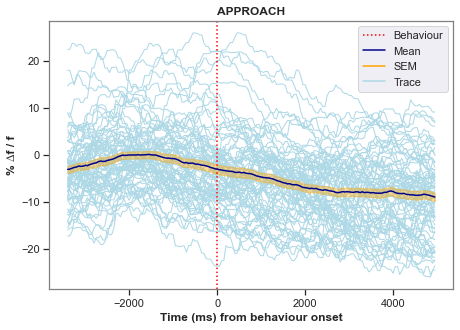

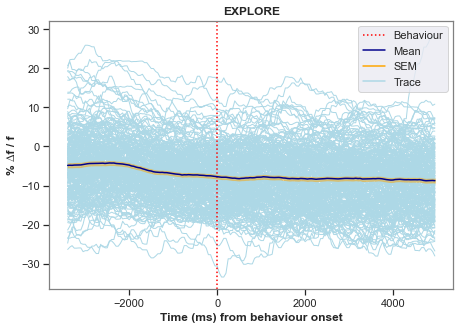

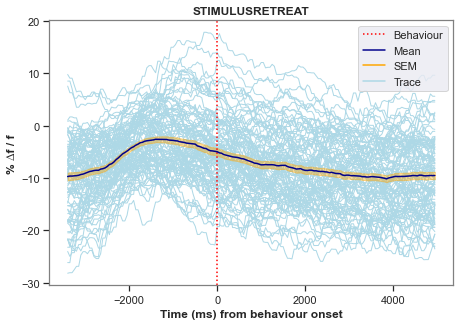

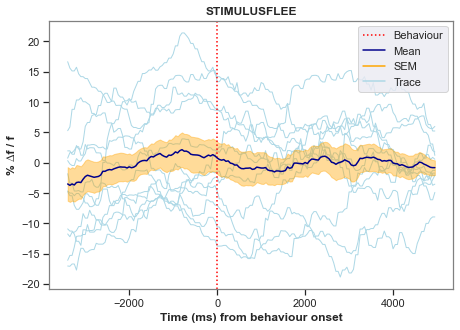

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
import emoji
##SEM not STD
##behaviour
sns.set()

def plot_behaviour_trace(photom_hit_window, cur_behaviour, pre_post_secs):
    ##get index values (negative to positive ms)
    x = photom_hit_window[cur_behaviour].columns
    ##get the mean line of all traces
    mean = photom_hit_window[cur_behaviour].mean()
    ##get the standard error of the mean
    sem = photom_hit_window[cur_behaviour].sem()
    ##plot each individual trace
    [plt.plot(pre_post_secs, i, 'lightblue', label='mean_1', linewidth=1,  zorder=1) for i in photom_hit_window[cur_behaviour].values]
    ##shade the SEM area
    plt.fill_between(pre_post_secs, mean - sem, mean + sem, color='orange', alpha=0.4, zorder=2)
    ##plot the mean trace
    plt.plot(pre_post_secs, mean, 'darkblue', label='mean_1', zorder=3)  
    ##get current axis, i dont really get it but it lets you change chart settings
    ax = plt.gca()
    ##make the chart background white
    ax.set_facecolor('white')
    ##set the little ticks to be black
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    ##remove the background grid
    ax.grid(False)
    ##remove unneccessary white space
    plt.tight_layout(pad=0)
    ##get the largest value in the dataset
    max_of_all = photom_hit_window[cur_behaviour].values.max()
    ##draw a line to this point (though im pretty sure this draws an infinite line anyway)
    plt.axline((0,0), (0,max_of_all), linestyle='dotted', color='red')
    ##make sure ticks are on the bottom and left
    plt.tick_params(bottom=True, left=True)
    ##set the plot title to the current behaviour in all caps
    plt.title(cur_behaviour.upper(), fontweight='bold')
    ##manually create a legend using the same lines i used for each type of trace
    lines = [matplotlib.lines.Line2D((0,1),(0,1),linestyle = 'dotted', color='red'), matplotlib.lines.Line2D((0,1),(0,1), color='darkblue'), matplotlib.lines.Line2D((0,1),(0,1), color='orange'),  matplotlib.lines.Line2D((0,1),(0,1), color='lightblue')]
    ##draw the legend and place it in the top right
    ax.legend(lines, ['Behaviour', 'Mean', 'SEM', 'Trace'], loc='upper right')
    ##X axis label
    matplotlib.pyplot.xlabel('Time (ms) from behaviour onset',  fontweight='bold')
    ##Y axis label
    matplotlib.pyplot.ylabel('% ∆f / f',  fontweight='bold')
    ##Save figure as an SVG
    plt.savefig(cur_behaviour+"mean_trace.svg", bbox_inches='tight')
    ##Display current figure in the notebook
    plt.show()
    
for beh in unique_behaviours:
    plot_behaviour_trace(photom_hit_window, beh, pre_post_secs)


ratio: (10, 10, 158)


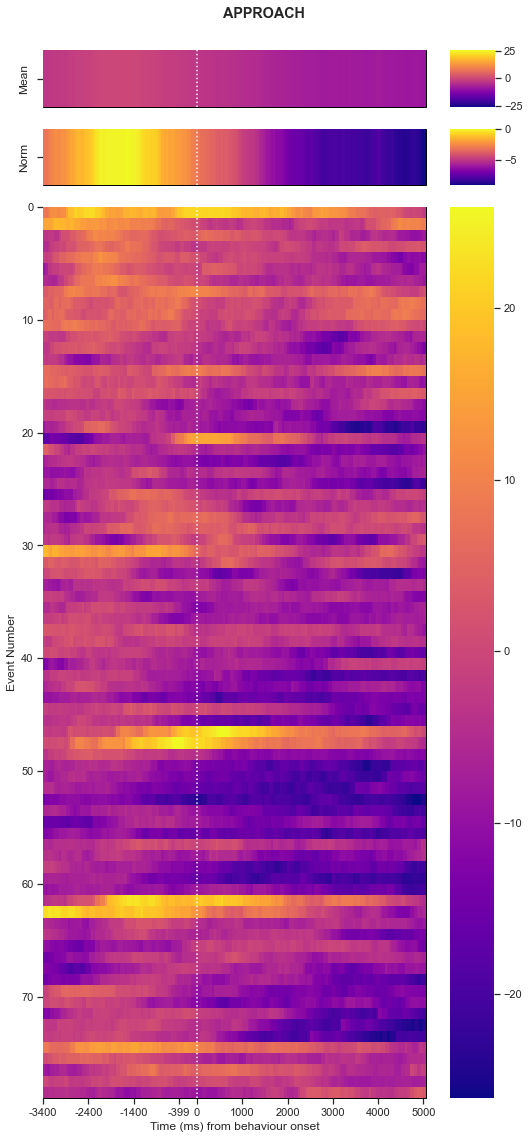

ratio: (10, 10, 239)


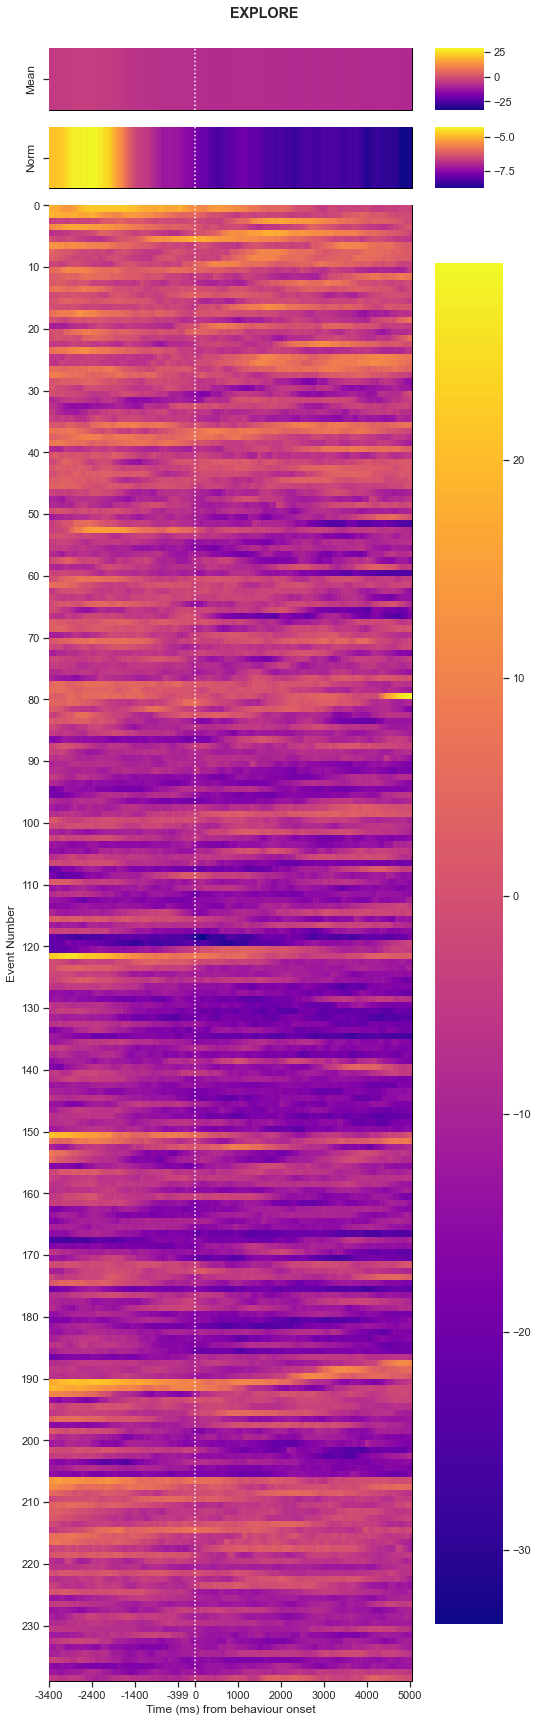

ratio: (10, 10, 101)


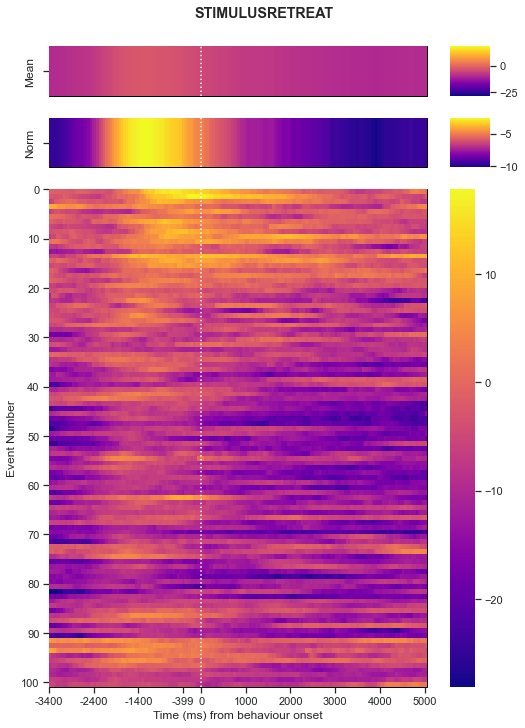

ratio: (10, 10, 108)


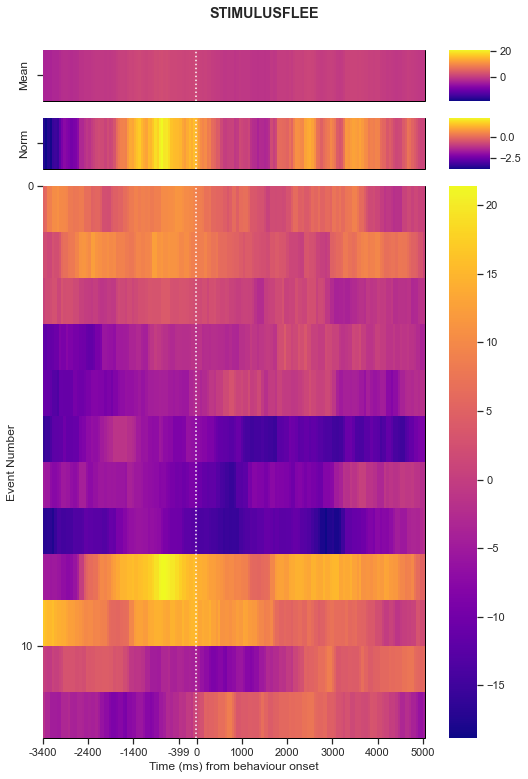

In [10]:
def add_margin(ax,xm=0.1,ym=0.05):
    """adds a margin to a pyplot"""
    ##get min and max position of the X axis
    xlim = ax.get_xlim()
    ##get min and max position of the Y axis
    ylim = ax.get_ylim()
    ##change min and max X by 0.1 (adding a 10% margin)
    ax.set_xlim(xlim[0]-xm,xlim[1]+xm)
    ##change min and max Y by 0.05 (adding a 5% margin)
    ax.set_ylim(ylim[0]+ym,ylim[1]-ym)
    
def zero_x_labels(pre_window_secs, post_window_secs, heatmap):
    """aligns labels and data, ensuring a label at zero"""
    ##arange from the pre_window to zero, with increment of one second
    neg_ticks = np.arange(-pre_window_secs, 0)
    ##arange from zero to the post_window, with increment of one second
    pos_ticks = np.arange(0, post_window_secs)
    ##append these to each other
    pos_ticks = np.append(pos_ticks, post_window_secs)
    ##convert to ms
    labels = np.append(neg_ticks, pos_ticks)*1000
    ##ticks are integer position of the data and need to line up with the correct labels
    ticks=labels+abs(labels[0])
    ticks/=ticks[-1]
    ticks*=heatmap.shape[1]-1
    return labels, ticks

def create_heatmap(photom_hit_window, behaviour, pre_window_secs, post_window_secs):
    """creates a heatmap of data"""
    ##get all the traces for the current behaviour
    heatmap = photom_hit_window[behaviour].values
    ##align X labels and data 
    labels, ticks = zero_x_labels(pre_window_secs, post_window_secs, heatmap)
    ##get the average trace
    avg_heat = np.mean(heatmap, axis=0).reshape(1, np.shape(heatmap)[1])
    ##if heatmap is shape is under 100, increase each row height by 1 pix until it is >=100
    heatmap_scale = np.ceil(100/heatmap.shape[0])
    heatmap = np.repeat(heatmap,heatmap_scale, axis=0)
    ##create a blank canvas with three plots (3 rows 1 column), the ratio is such that the first two rows will always be the same size
    print(f"ratio: {(10, 10, np.shape(heatmap)[0])}")
    f, axs = plt.subplots(figsize=(7.5, len(heatmap)*0.1), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [10, 10, np.shape(heatmap)[0]]})


    ##set the background of all plots to white
    for ax in axs: ax.set_facecolor('white')
    ##plot the average but make sure the min and max colours are the same as the main plot
    sns.heatmap(avg_heat,linewidths=0, cmap="plasma", rasterized=True, cbar=True, ax=axs[0],cbar_kws={'aspect':1.25}, vmin=np.min(heatmap), vmax=np.max(heatmap))
    ##now plot it again but let the colours scale to min and max "normalising" the plot
    sns.heatmap(avg_heat,linewidths=0, cmap="plasma", rasterized=True, cbar=True, ax=axs[1],cbar_kws={'aspect':1.25})
    ##now plot all the individual traces
    sns.heatmap(heatmap,linewidths=0, cmap="plasma", rasterized=True, cbar=True, ax=axs[2])
    ##set the title to the current behaviour in all caps
    f.suptitle(behaviour.upper(), fontweight='bold', y=1.0)
    ##label the X axis and label the main plot Y axis
    axs[-1].set(xlabel="Time (ms) from behaviour onset", ylabel="Event Number")
    ##label the Y axis of mean
    axs[0].set(ylabel="Mean")
    ##label the Y axis of mean
    axs[1].set(ylabel="Norm")
    ##make sure all three plots have the same indexes and labels
    axs[0].axline((int(ticks[labels==0])+0.5,0), (int(ticks[labels==0])+0.5,1), linestyle=':', color='white')
    axs[1].axline((int(ticks[labels==0])+0.5,0), (int(ticks[labels==0])+0.5,1), linestyle=':', color='white')
    axs[2].axline((int(ticks[labels==0])+0.5,0), (int(ticks[labels==0])+0.5,1), linestyle=':', color='white')
    ##set the yticks of the main plot
    plt.yticks(ticks=np.arange( 0,len(heatmap), 10*heatmap_scale), labels=np.arange( 0,int(len(heatmap)/heatmap_scale), 10))
    plt.xticks(ticks=ticks, labels=labels.astype(np.int64), rotation=0)
    ##ticks are on the bottom and left
    plt.tick_params(bottom=True, left=True)
    ##mean and norm plots have a tick
    axs[0].tick_params(left=True)
    axs[1].tick_params(left=True)
    ##dont label the mean and norm ticks with a number
    empty_string_labels = ['']
    axs[0].set_yticklabels(empty_string_labels)
    axs[1].set_yticklabels(empty_string_labels)
    ##remove unneccesary white space
    f.tight_layout()
    ##set the edges of the plot to be black and have a width of 1 
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    ##remove the background grid
    plt.grid(False)
    ##set the edge colour and line width of all plots
    for ax in axs: ax.patch.set_edgecolor('black')  
    for ax in axs: ax.patch.set_linewidth('1')  
    ##save the figure as an SVG
    plt.savefig(f"{behaviour}_behaviour_trace_heatmap.svg", bbox_inches='tight')
    ##show it inline in the notebook
    plt.show()
for behaviour in unique_behaviours:
    create_heatmap(photom_hit_window, behaviour, pre_window_secs, post_window_secs)


The scored behaviour and DLC files are not the same length!
The DLC file is 83944 frames shorter than the scored behaviour
we may proceed but make sure they are from the same experiment


C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\harry\miniconda3\envs\Data_Analysis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<h1><strong>CODE GRAVEYARD BEYOND THIS POINT</strong></h1>
<b1>proceed at own risk</b1>

upscaling...
upscaling...
(200, 200)
smoothing...


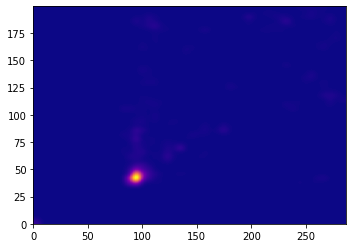

In [131]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

##Get x and y coords
x,y  = mean_x, mean_y
##bin coords in a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print('upscaling...')
print('upscaling...')
scale_factor=4
heatmap_big = np.kron(heatmap, np.ones((scale_factor,scale_factor)))
print(heatmap_big.shape)
print('smoothing...')
heatmap_smooth = gaussian_filter(heatmap_big, sigma=scale_factor/2)

plt.clf()
##cmap gives it a cool firey look
plt.imshow(heatmap_smooth.T, cmap = 'plasma',extent=extent, origin='lower')
plt.show()

In [135]:
heatmap.shape

(50, 50)

In [223]:
# xcopy = xcopy.values
# ycopy = ycopy.values



In [214]:
box_long = [i for i in box_grids if len(i)>1]

upscaling...
upscaling...


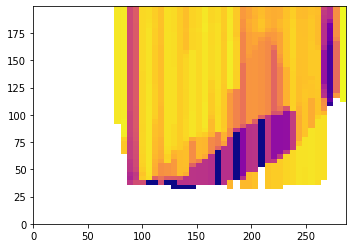

In [236]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

##Get x and y coords
x,y  = mean_x, mean_y
##bin coords in a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
xprev = 0
yprev = 0
box_grids = []
heat = []
for xgrid in xedges[1:]:
    for ygrid in yedges[1:]:
        isin_box = (mean_x>xprev) & (mean_y>yprev) & (mean_x<xgrid) & (mean_y<ygrid)
        grid_index = np.where(isin_box)[0]
        heat.append(np.mean(photom.signal.iloc[grid_index]))
    xprev = xgrid
print('upscaling...')

print('upscaling...')
heatmap=np.reshape(heat, (50,50))

# scale_factor=4
# heatmap_big = np.kron(heatmap, np.ones((scale_factor,scale_factor)))
# print(heatmap_big.shape)
# print('smoothing...')
# heatmap_smooth = gaussian_filter(heatmap_big, sigma=scale_factor/2)

plt.clf()
##cmap gives it a cool firey look
plt.imshow(heatmap.T, cmap = 'plasma',extent=extent, origin='lower')
plt.show()

In [231]:
heatmap.shape

(50, 50)

In [64]:
    heatmap = np.repeat(heatmap,np.ceil(100/heatmap.shape[0]), axis=0).shape


In [201]:
(mean_y> 47.87988098) & (mean_y<51.86987106)

array([False, False, False, ...,  True,  True,  True])

In [198]:
mean_y

199.49950408935547

In [358]:
xmin = np.min(pre_post_secs)
xmax =  np.max(pre_post_secs)
labels = (np.round(np.linspace(xmin, xmax, 5), -2))
xmin = 0
xmax =  len(pre_post_secs)
ticks = (np.linspace(xmin, xmax, 5))

(101, 160)


NameError: name 'cur_behaviour' is not defined

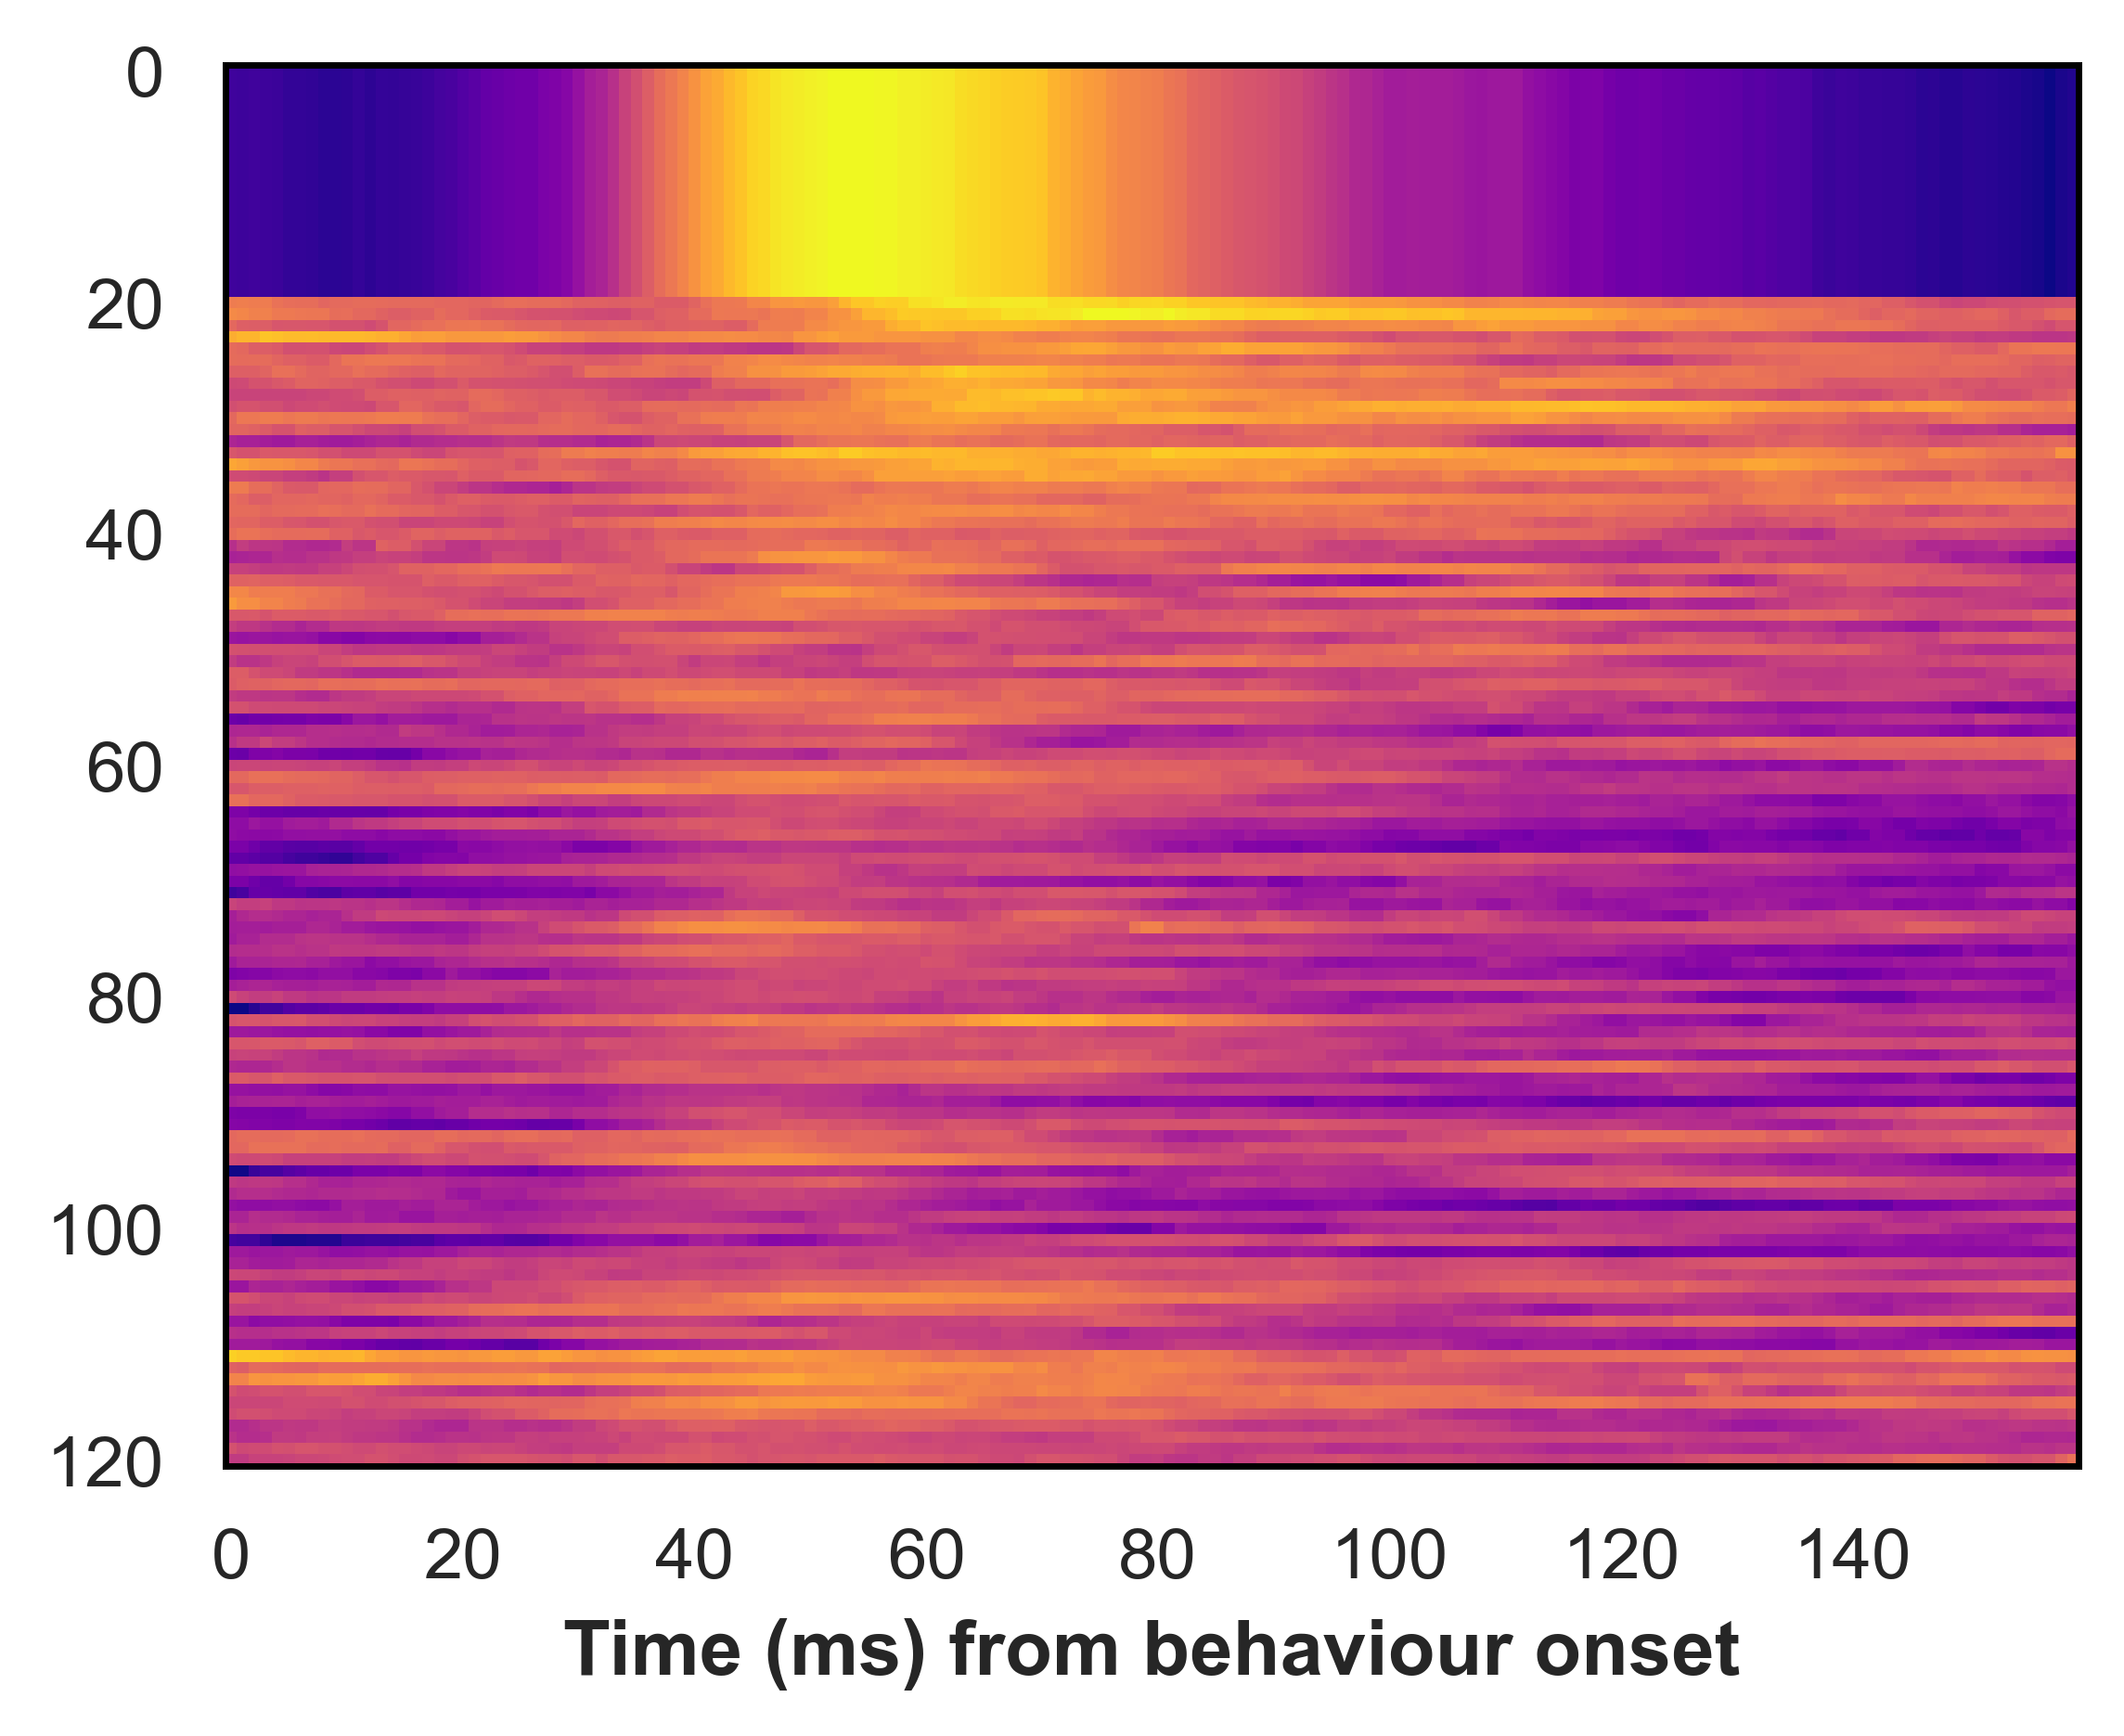

In [612]:
##TODO make ticks adjust based on prepost

heatmap = np.repeat(temp.values, 1, axis=0)

avg_heat = np.mean(heatmap, axis=0)

# avg_heat = np.repeat(avg_heat[:,np.newaxis], 20, axis=1).T

print(heatmap.shape)
heatmap = np.row_stack((avg_heat_scaled, heatmap))
# heatmap = np.array(heatmap)

plt.clf()
plt.grid(False)
###imshow auto min max s
plt.xlabel('Time (ms) from behaviour onset',  fontweight='bold')
plt.imshow(heatmap, cmap=plt.get_cmap('plasma'),interpolation='none', aspect='equal')


plt.xticks(ticks=ticks, labels=labels)
# plt.locator_params(numticks=10)

plt.savefig("short_Behaviour_Trace.svg", bbox_inches='tight')

plt.show()

In [59]:
np.ceil(1.1)

2.0

(158, 102)

In [255]:
##MinMax Scale feature
H_std = (avg_heat - avg_heat.min()) / (avg_heat.max() - avg_heat.min())
avg_heat_scaled = H_std * (heatmap.max() - heatmap.min()) + heatmap.min()

In [686]:
plt.savefig("short_Behaviour_Trace.png", bbox_inches='tight')


<Figure size 3000x2000 with 0 Axes>

In [ ]:
axs[0].tick_params

In [723]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

In [308]:
new_ticks = np.arange(np.min(pre_post_secs), np.max(pre_post_secs)+50, 1000)
new_ticks

array([-4000., -3000., -2000., -1000.,     0.,  1000.,  2000.,  3000.])

In [96]:
plt.rcParams['axes.facecolor']=''
plt.rcParams['savefig.facecolor']='white'

In [47]:
lines

In [476]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise 

In [33]:
unique_behaviours[unique_behaviours!='Nothing']

array(['Rearing', 'Jump', 'Shake', 'Grooming', 'Digging', 'Tremor'],
      dtype=object)